In [1]:
from MITgcmutils.utils import writebin
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ocean_utils import *

xrg = 180
yrg = 48
dx = 1/4     # grid spacing in x (degrees longitude)
dy = 1/4     # grid spacing in y (degrees latitude)
nz = 35    # gridpoints in z
nx, ny = int(xrg//dx), int(yrg//dy)   # gridpoints in x

print('Nx,Ny,Nz=',nx,ny,nz)

x0 = 112     # origin in x,y for ocean domain
y0 = -23    # (i.e. southwestern corner of ocean domain)
x1 = x0 + (nx-1)*dx    # origin in x,y for ocean domain
y1 = y0 + (ny-1)*dy    # (i.e. southwestern corner of ocean domain)

opath = '../input/'

# ipath = '/mnt/d/project/IAVNNG/Data/'
# ipath = '../../IAVNNG/data/'
ipath = '../../data/'
# input files
fbath = ipath + 'GLO-MFC_001_030_mask_bathy.nc'
fclim = ipath + 'cmems_climatology_mon.nc'
fsflux = ipath + 'era5_surfflux_mon.nc'
fsvar = ipath + 'era5_surfvar_mon.nc'
fwlsm = ipath + 'era5_lsm.nc'

inc = round(dx*12)
winc = round(dx*4)

Nx,Ny,Nz= 720 192 35


## 生成海表面强迫场（标量形式：风速、温度、降水，下行辐射，Agrid）

In [2]:
do_clim = True # 是否气候态
do_smooth = False  # 是否平滑
wedge = 3

# 时间和空间切片
tsl = slice('2000-01', '2019-12')
yisl = slice(y0-wedge,y1+wedge,-1)
xisl = slice(x0-wedge,x1+wedge)
yosl = slice(y0, y1, winc)
xosl = slice(x0, x1, winc)
lsm  = xr.open_dataset(fwlsm)['lsm'].loc[yisl,xisl].values<0.5

ds = xr.open_dataset(fsvar).sel(valid_time=tsl,latitude=yisl,longitude=xisl)

var_names = ['u10','v10','t2m','sh2m','avg_tprate','avg_sdswrf','avg_sdlwrf']
# 存储处理后数据的字典
result = {}
for var in var_names:
    data = ds[var].load()
    # 如果需要气候态（月平均）
    if do_clim:
        data = data.groupby('valid_time.month').mean('valid_time')
    # 统一空间平滑（如果开启）
    if do_smooth:
        data.values = gsmooth2d(data.values,sigma=winc / 3,mask=lsm,threshold=0.1,fill_value=0)
    # 最终裁剪到目标区域
    data = data.loc[:, yosl, xosl]
    # 转为 numpy 数组并存入字典
    result[var] = data.values
    print(f"{var} shape: {result[var].shape}")

aqh = result['sh2m']  # 比湿
swdown = result['avg_sdswrf']  # 单独的短波辐射通量
lwdown = result['avg_sdlwrf']  # 下行长波辐射
precip = result['avg_tprate']/1e3 # 单位转换,mit以淡水流失为正（era5的以淡水输入为正）

# 保存为MITgcm驱动所需的二进制文件
writebin(opath+'exf_uwind.bin',result['u10'])
writebin(opath+'exf_vwind.bin',result['v10'])
writebin(opath+'exf_atemp.bin',result['t2m'])
writebin(opath+'exf_aqh.bin', aqh)
writebin(opath+'exf_swdown.bin',swdown)
writebin(opath+'exf_lwdown.bin',lwdown)
writebin(opath+'exf_precip.bin',precip)

u10 shape: (12, 192, 720)
v10 shape: (12, 192, 720)
t2m shape: (12, 192, 720)
sh2m shape: (12, 192, 720)
avg_tprate shape: (12, 192, 720)
avg_sdswrf shape: (12, 192, 720)
avg_sdlwrf shape: (12, 192, 720)


## 生成海表面强迫场（通量形式：动量、热量、淡水，Agrid）


In [3]:
# do_clim = True # 是否气候态
# do_smooth = False  # 是否平滑
# wedge = 3

# 时间和空间切片
# tsl = slice('2000-01', '2019-12')
yisl = slice(y0-wedge,y1+wedge,-1)
xisl = slice(x0-wedge,x1+wedge)
yosl = slice(y0, y1, winc)
xosl = slice(x0, x1, winc)
lsm  = xr.open_dataset(fwlsm)['lsm'].loc[yisl,xisl].values<0.5

ds = xr.open_dataset(fsflux).sel(valid_time=tsl,latitude=yisl,longitude=xisl)

var_names = ['iews','inss','ie','tprate','slhtf','ishf','snlwrf','snswrf']
# 存储处理后数据的字典
result = {}
for var in var_names:
    data = ds['avg_' + var].load()
    # 如果需要气候态（月平均）
    if do_clim:
        data = data.groupby('valid_time.month').mean('valid_time')
    # 统一空间平滑（如果开启）
    if do_smooth:
        data.values = gsmooth2d(data.values,sigma=winc / 3,mask=lsm,threshold=0.1,fill_value=0)
    else:
        data.values[:,~lsm] = 0
    # 最终裁剪到目标区域
    data = data.loc[:, yosl, xosl]
    # 转为 numpy 数组并存入字典
    result[var] = data.values
    print(f"{var} shape: {data.values.shape}")

uflux = result['iews']
vflux = result['inss']
hflux = -(result['slhtf'] + result['ishf'] + result['snlwrf'] + result['snswrf']) # mit以热输出为正（era5的以热输入为正）
swflux = -result['snswrf']  # 单独的短波辐射通量
sflux = -(result['ie'] + result['tprate'])/1e3 # 单位转换,mit以淡水流失为正（era5的以淡水输入为正）
# 保存为MITgcm驱动所需的二进制文件
writebin(opath+'exf_ustress.bin',uflux)
writebin(opath+'exf_vstress.bin',vflux)
writebin(opath+'exf_hflux.bin',hflux)
writebin(opath+'exf_swflux.bin', swflux)
writebin(opath+'exf_sflux.bin',sflux)

iews shape: (12, 192, 720)
inss shape: (12, 192, 720)
ie shape: (12, 192, 720)
tprate shape: (12, 192, 720)
slhtf shape: (12, 192, 720)
ishf shape: (12, 192, 720)
snlwrf shape: (12, 192, 720)
snswrf shape: (12, 192, 720)


## 生成地形数据
---
需注意水深取负值，且将陆地填补为0

(601, 2401) (192, 720)


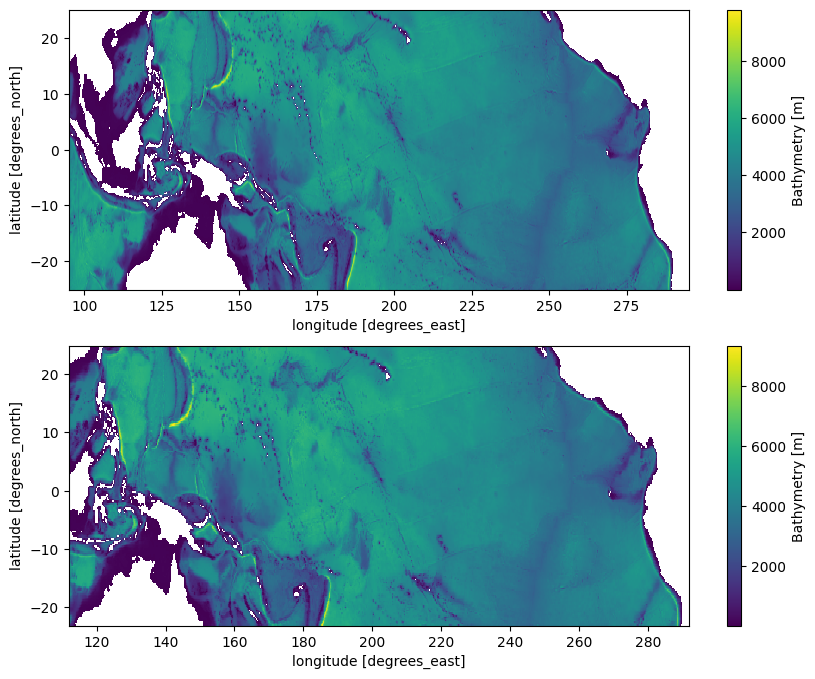

In [4]:
import matplotlib.pyplot as plt
import heapq
import numpy as np

xll,xrr = 95,295
yd,yu = -25,25
pts_l = [[121.51,yu],[143,yd]]
pts_r = [[260,yu],[290,yd]]
with xr.open_dataset(fbath) as ds:
    da = ds['deptho']
    hl = da.loc[yd:yu,xll:xrr]
    hr = da.loc[yd:yu,xll-360:xrr-360]
    hr['longitude'] = hr['longitude'] + 360
ho = xr.concat([hl,hr],dim='longitude')
col = ho.indexes['longitude'].get_indexer(list(zip(*pts_l))[0],method='nearest')
row = ho.indexes['latitude'].get_indexer(list(zip(*pts_l))[1],method='nearest')
ind_l = list(zip(row,col))
col = ho.indexes['longitude'].get_indexer(list(zip(*pts_r))[0],method='nearest')
row = ho.indexes['latitude'].get_indexer(list(zip(*pts_r))[1],method='nearest')
ind_r = list(zip(row,col))
wm = ho.values.copy()
wm+=100
wm[np.isnan(wm)] = 0
wm += 200

path_l,_ = astar_2d(wm,*ind_l)
path_r,_ = astar_2d(wm,*ind_r)

# 根据路径设置水深为np.nan
h_arr = ho.values.copy()
# 西侧覆盖
# for r, c in path_l:
#     h_arr[r, c] = np.nan
# 东侧覆盖
for r, c in path_r:
    h_arr[r, c] = np.nan
mask_ho = ~largest_connected_region(~np.isnan(h_arr))
ho.values[mask_ho] = np.nan
ho.values = gsmooth2d(ho.values,sigma=inc/3, norm=False)
h = ho.loc[y0:y1:inc,x0:x1:inc]

plt.figure(figsize=(10,8))
plt.subplot(211)
ho.plot()
# 可视化结果
plt.subplot(212)
h.plot()

h = h.values.copy()
h[np.isnan(h)] = 0
h = -h
print(ho.shape,h.shape)
writebin(opath+'bathy.bin',h)

## 基于再分析气候态数据 生成边界条件

### 分割垂向网格

In [5]:
import xarray as xr
# new vertical grid
ds = xr.open_dataset(fclim)
dep = ds['depth'].values
dr = np.zeros(dep.shape)
lev = 0
for i in range(dep.size):
    dr[i] = 2*(dep[i]-lev)
    lev += dr[i]
# Rid = [0,14,19,22,24]+[id for id in range(25,dep.size)]
Rid = [0,6,10,13,16,18,20,21,22,23,24]+[id for id in range(25,dep.size)]
dR = np.zeros(len(Rid)-1)
for i in range(len(Rid)-1):
    dR[i] = dr[Rid[i]:Rid[i+1]].sum()
print('Nr  = {:4d}'.format(len(dR)))
print('delR='+''.join(f"{x:.0f}.," for x in dR))
print('intR='+''.join(f"{x:.0f}.," for x in dR.cumsum()))

Nr  =   35
delR=7.,7.,9.,14.,14.,20.,13.,16.,19.,23.,27.,33.,40.,48.,57.,68.,80.,94.,111.,129.,149.,171.,195.,219.,245.,270.,296.,321.,344.,366.,386.,405.,421.,435.,448.,
intR=7.,15.,23.,37.,51.,71.,84.,100.,119.,142.,170.,203.,242.,290.,346.,414.,494.,588.,699.,828.,977.,1148.,1343.,1562.,1807.,2077.,2373.,2694.,3038.,3404.,3790.,4195.,4616.,5051.,5499.,


### 生成温盐流初始场

In [6]:
ds = xr.open_dataset(fclim)

var_names = ['uo','vo','thetao','so']
# 存储处理后数据的字典
result = {}
for var in var_names:
    # 一月气候态平均作为初始场
    data = ds[var][0].load()
    data.values[:,mask_ho] = np.nan
    data.values = gsmooth2d(data.values,sigma=inc/3,threshold=0.1)
    data = data.loc[:,y0:y1:inc,x0:x1:inc]
    data = data.values
    for i in range(data.shape[0]):
        data[i] = fillna(data[i])
    datai = np.zeros((nz,ny,nx))
    for i in range(nz):
        datai[i] = (data[Rid[i]:Rid[i+1]]*dr[Rid[i]:Rid[i+1],None,None]).sum(0)/dR[i,None,None]
    result[var] = datai
    print(f"{var} shape: {datai.shape}")

# 特殊处理海面高度
var = 'zos'
data = ds[var][0].load()
data.values[mask_ho] = np.nan
data.values = gsmooth2d(data.values,sigma=inc/3,threshold=0.1)
data = data.loc[y0:y1:inc,x0:x1:inc]
data = fillna(data.values)
print(f"{var} shape: {data.shape}")
    

writebin(opath+'init_P.bin',data)
writebin(opath+'init_U.bin',result['uo'])
writebin(opath+'init_V.bin',result['vo'])
writebin(opath+'init_T.bin',result['thetao'])
writebin(opath+'init_S.bin',result['so'])


uo shape: (35, 192, 720)
vo shape: (35, 192, 720)
thetao shape: (35, 192, 720)
so shape: (35, 192, 720)
zos shape: (192, 720)


### 生成EXF Relax边界（SSH SSS Agrid）

(12, 601, 2401) (601, 2401)
(12, 192, 720)


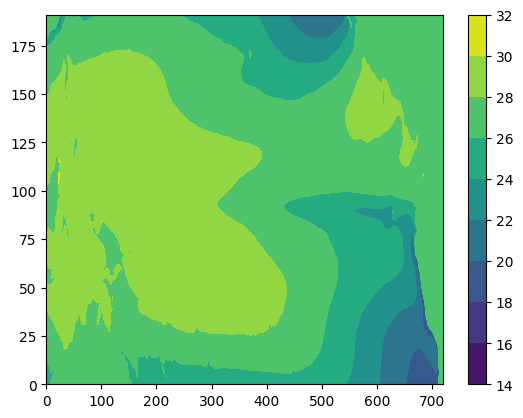

In [7]:
ds = xr.open_dataset(fclim)
thetao = (ds['thetao'][:,:Rid[1]]*dr[:Rid[1],None,None]).sum('depth')/dR[0,None,None]
so = (ds['so'][:,:Rid[1]]*dr[:Rid[1],None,None]).sum('depth')/dR[0,None,None]
print(thetao.shape, mask_ho.shape)
thetao.values[:, mask_ho] = np.nan
so.values[:, mask_ho] = np.nan

thetao.values = gsmooth2d(thetao.values,sigma=inc/3,threshold=0.1,fill_value=28)
so.values = gsmooth2d(so.values,sigma=inc/3,threshold=0.1,fill_value=34)
thetao = thetao.loc[:,y0:y1:inc,x0:x1:inc]
so = so.loc[:,y0:y1:inc,x0:x1:inc]
theta, s = thetao.values, so.values
plt.contourf(theta.mean(0))
plt.colorbar()
print(theta.shape)
writebin(opath+'sst_clim.bin',theta)
writebin(opath+'sss_clim.bin',s)

### 生成侧边界条件

In [8]:
# 生成温盐流侧边界（T/S/U/V）
bd = 1
obcs = ['S','N','W']
varname = ['thetao','so','uo','vo']
xsi_map = {'W': slice(x0-bd, x0+bd), 'E': slice(x1-bd, x1+bd)}
ysi_map = {'S': slice(y0-bd, y0+bd), 'N': slice(y1-bd, y1+bd)}
xso_map = {'W': x0,'E': x1}
yso_map = {'S': y0,'N': y1}

ds = xr.open_dataset(fclim)
for obc in obcs:
    print(f'处理{obc}边界')
    xsi = xsi_map.get(obc, slice(None))
    ysi = ysi_map.get(obc, slice(None))
    xso = xso_map.get(obc, slice(x0,x1,inc))
    yso = yso_map.get(obc, slice(y0,y1,inc))
    for vn in varname:
        arr = ds[vn].loc[:,:,ysi,xsi].load()
        # 掩膜obs
        mask = np.isnan(ho.loc[ysi,xsi].values)
        arr.values[:,:, mask] = np.nan
        # 平滑
        arr.values = gsmooth2d(arr.values, sigma=inc/3, threshold=0.1)
        # 插值到目标网格
        arr = arr.loc[:, :, yso, xso]
        arr = arr.values
        # 填充缺失值
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                arr[i,j] = fillna(arr[i,j])
        # 垂向加权平均（T/S/U/V都处理）
        arr_new = np.zeros((arr.shape[0],nz, arr.shape[2]))
        for k in range(nz):
            arr_new[:,k] = (arr[:,Rid[k]:Rid[k+1]]*dr[Rid[k]:Rid[k+1],None]).sum(1)/dR[k,None]
        print(f'{obc}_{vn[0].upper()} shape:', arr_new.shape)
        writebin(f"{opath}OB_{obc}_{vn[0].upper()}.bin", arr_new)

处理S边界


S_T shape: (12, 35, 720)
S_S shape: (12, 35, 720)
S_U shape: (12, 35, 720)
S_V shape: (12, 35, 720)
处理N边界
N_T shape: (12, 35, 720)
N_S shape: (12, 35, 720)
N_U shape: (12, 35, 720)
N_V shape: (12, 35, 720)
处理W边界
W_T shape: (12, 35, 192)
W_S shape: (12, 35, 192)
W_U shape: (12, 35, 192)
W_V shape: (12, 35, 192)
